In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
#import warnings
from copy import deepcopy

from Classes.marketmodel_interface import MarketModel
from Classes.simulation_interface import Simulation

#### Import data for calibration
CAC40

In [2]:
# Create dictionary to store dataFrames for the 40 CAC40 companies
Data10y_dic = {}

# Get list of files containing 'Data' in the "Data/CAC40 daily 10y"
directory = "Data/CAC40 daily 10y"
files = [f for f in os.listdir(directory) if 'Data' in f]
# Process each file
for file in files:
    # Get company name (first word before '_')
    company = file.split('_')[0]
    
    # Read the file with tab separator
    df = pd.read_csv(os.path.join(directory, file), sep='\t')
    
    # Convert first column to datetime and set as index
    df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

    df = df.drop('date', axis=1)  # Remove the original date column
    df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
    
    # Store in dictionary
    Data10y_dic[company] = df

# Create a DataFrame with all the closing prices
dfs = [df['clot'] for df in Data10y_dic.values()]
histo_CAC40 = pd.concat(dfs, axis=1, keys=Data10y_dic.keys())
histo_CAC40 = histo_CAC40.sort_index()

data = histo_CAC40.dropna()
nb_stocks = 40
allocations_EW = np.ones(nb_stocks) / nb_stocks
# Import the weights data of CAC40
CAC40_weights_df = pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Company')
# Convert string values to float
CAC40_weights = CAC40_weights_df.iloc[0, :].str.replace(',', '.').astype(float).values


In [20]:
evolution_data = np.log(data / data.shift() )
evolution_data.iloc[0,:] = 0.0
evolution_data

begin_date_data = str(data.index[0])[:10]
end_date_data = str(data.index[-1])[:10]

In [22]:
end_date_data

'2025-03-07'

#### Create Black-Scholes model and calibrate it with data

In [4]:
# Create a MarketModel object
market_model_BS_CAC40 = MarketModel(model_name="BS")
market_model_BS_CAC40.fit(data)

#### Simulation with historical data

#### Simulations without constraints

In [5]:
nb_simu = 50
#allocation = allocations_EW
allocation = CAC40_weights

parameters_BuyH = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Allocation": allocation,
}
simulation_BuyH = Simulation(nb_scenarios=nb_simu, model=market_model_BS_CAC40, strategy="Buy and hold", parameters=parameters_BuyH)
simulation_BuyH.generate_scenarios()
simulation_BuyH.generate_evolutions()

parameters_Rebal20 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Allocation": allocation,
    "Rebalancing period": 20
}
simulation_Rebal20 = Simulation(nb_scenarios=nb_simu, model=market_model_BS_CAC40, strategy="Rebalancing", parameters=parameters_Rebal20)
simulation_Rebal20.set_scenarios(simulation_BuyH.scenarios)
simulation_Rebal20.generate_evolutions()

parameters_Rebal5 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Allocation": allocation,
    "Rebalancing period": 5
}
simulation_Rebal5 = Simulation(nb_scenarios=nb_simu, model=market_model_BS_CAC40, strategy="Rebalancing", parameters=parameters_Rebal5)
simulation_Rebal5.set_scenarios(simulation_BuyH.scenarios)
simulation_Rebal5.generate_evolutions()

In [ ]:
#Historique


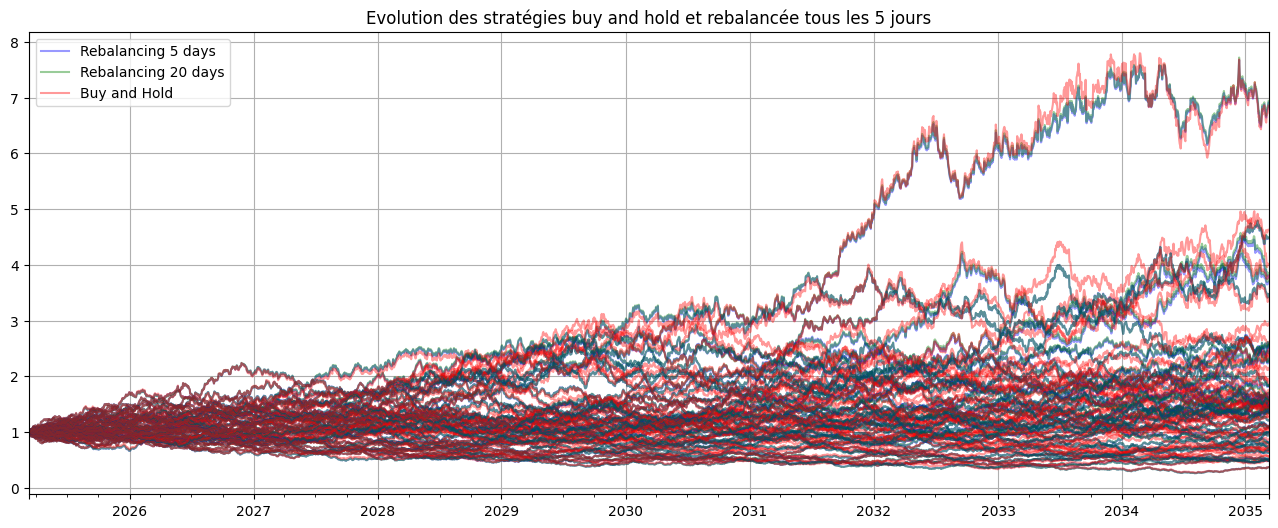

In [7]:
plt.figure(figsize=(16, 6))

lines = []
evolution_rebal5 = simulation_Rebal5.evolutions
evolution_BuyH = simulation_BuyH.evolutions
evolution_rebal20 = simulation_Rebal20.evolutions

for evolution_name, evolution_data in evolution_rebal5.items():
    lines.append(evolution_data.sum(axis=1).plot(color="blue", alpha=0.4, label="Rebalancing 5 days"))
    lines.append(evolution_rebal20[evolution_name].sum(axis=1).plot(color="green", alpha=0.4, label="Rebalancing 20 days"))
    lines.append(evolution_BuyH[evolution_name].sum(axis=1).plot(color="red", alpha=0.4, label="Buy and Hold"))

plt.title("Evolution des stratégies buy and hold et rebalancée tous les 5 jours")
plt.grid()

# Get unique legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

#### Simulations with constraints

In [8]:
Nsce = 500

parameters_BuyH_sous_constrains = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10'
}
Data_esg = (pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Company').iloc[1:, :]).T
#string to float
Data_esg = Data_esg.apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)
simulation_BuyH_sous_constrains = Simulation(nb_scenarios=Nsce, model=market_model_BS_CAC40, strategy="Buy and hold", parameters=parameters_BuyH_sous_constrains)
simulation_BuyH_sous_constrains.set_dataESG(Data_esg)
contraints = {
    "List" : ["Maximal allocation", "Maximal volatility", "Maximal Carbon risk", "Maximal Carbon intensity (Tons of CO2)", "Minimal Score management"],
    "Value" : [0.2, 0.20, 3.5, 40, 65]
}
simulation_BuyH_sous_constrains.set_contraints(contraints)
simulation_BuyH_sous_constrains.compute_allocation()
simulation_BuyH_sous_constrains.generate_scenarios()
simulation_BuyH_sous_constrains.generate_evolutions()

# New simulation
# rebalance all 20 days and relax the constraints
parameters_BuyH_sous_constrains2 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Rebalancing period": 20
}
simulation_BuyH_sous_constrains2 = deepcopy(simulation_BuyH_sous_constrains)
simulation_BuyH_sous_constrains2.set_parameters(parameters_BuyH_sous_constrains2)
contraints2 = {
    "List" : ["Maximal allocation", "Maximal volatility", "Maximal Carbon risk", "Maximal Carbon intensity (Tons of CO2)", "Minimal Score management"],
    "Value" : [0.2, 0.25, 7, 2000, 50]
}
simulation_BuyH_sous_constrains2.set_contraints(contraints2)
simulation_BuyH_sous_constrains2.compute_allocation()
simulation_BuyH_sous_constrains2.generate_evolutions()

c:\Users\Billn\Documents\M2QF\Cutting edge\Cutting-edge\Classes\simulation_interface.py:45: UserWarning: Strategy changed to 'Rebalancing'. Positive rebalancing period is not needed for Buy and hold strategy.
To avoid this warning, please use set_strategy() method to change the strategy before updating parameters.
  warnings.warn("Strategy changed to 'Rebalancing'. Positive rebalancing period is not needed for Buy and hold strategy.\n"


In [9]:
returns = market_model_BS_CAC40.parameters["Returns"]
volatilities = market_model_BS_CAC40.parameters["Volatilities"]
Correlation_matrix = market_model_BS_CAC40.parameters["Correlation matrix"]

#print vol et rendement allocation
allocation = simulation_BuyH_sous_constrains.parameters["Allocation"]
covMatrix = np.diag(volatilities) @ Correlation_matrix @ np.diag(volatilities)
portfolio_return = allocation @ returns
portfolio_variance = allocation @ covMatrix @ allocation
portfolio_Carbon_risk = allocation @ Data_esg["Carbon risk"]
portfolio_Carbon_intensity = allocation @ Data_esg["Carbon intensity (Tons of CO2)"]
portfolio_score_management = allocation @ Data_esg["Score management"]

print("Portfolio 1:")
print(f"Portfolio return : {portfolio_return}")
print(f"Portfolio volatility: {np.sqrt(portfolio_variance)}")
print(f"Portfolio Carbon risk: {portfolio_Carbon_risk}")
print(f"Portfolio Carbon intensity: {portfolio_Carbon_intensity}")
print(f"Portfolio Score management: {portfolio_score_management}")


#print vol et rendement allocation
allocation2 = simulation_BuyH_sous_constrains2.parameters["Allocation"]
portfolio_return2 = allocation2 @ returns
portfolio_variance2 = allocation2 @ covMatrix @ allocation2
portfolio_Carbon_risk2 = allocation2 @ Data_esg["Carbon risk"]
portfolio_Carbon_intensity2 = allocation2 @ Data_esg["Carbon intensity (Tons of CO2)"]
portfolio_score_management2 = allocation2 @ Data_esg["Score management"]
print("\nPortfolio 2:")
print(f"Portfolio return: {portfolio_return2}")
print(f"Portfolio volatility: {np.sqrt(portfolio_variance2)}")
print(f"Portfolio Carbon risk: {portfolio_Carbon_risk2}")
print(f"Portfolio Carbon intensity: {portfolio_Carbon_intensity2}")
print(f"Portfolio Score management: {portfolio_score_management2}")

Portfolio 1:
Portfolio return : 0.1440651295165082
Portfolio volatility: 0.20000000000401058
Portfolio Carbon risk: 3.4999999900190604
Portfolio Carbon intensity: 39.99999985511599
Portfolio Score management: 65.00000000676678

Portfolio 2:
Portfolio return: 0.15362867220977938
Portfolio volatility: 0.23341777879206424
Portfolio Carbon risk: 6.99999999042541
Portfolio Carbon intensity: 47.323474765408335
Portfolio Score management: 63.142105331918486


In [10]:
simulation_BuyH_sous_constrains.compute_metrics()
print(simulation_BuyH_sous_constrains.metrics)
print("\n")
simulation_BuyH_sous_constrains2.compute_metrics()
print(simulation_BuyH_sous_constrains2.metrics)

{'Mean terminal value': 1.5062, 'Median terminal value': 1.2404, 'Volatility of terminal value': 1.0341, 'VaR(95.0%)': 0.4512, 'ES(95.0%)': 0.349}


{'Mean terminal value': 1.5929, 'Median terminal value': 1.2085, 'Volatility of terminal value': 1.2328, 'VaR(95.0%)': 0.3802, 'ES(95.0%)': 0.2996}


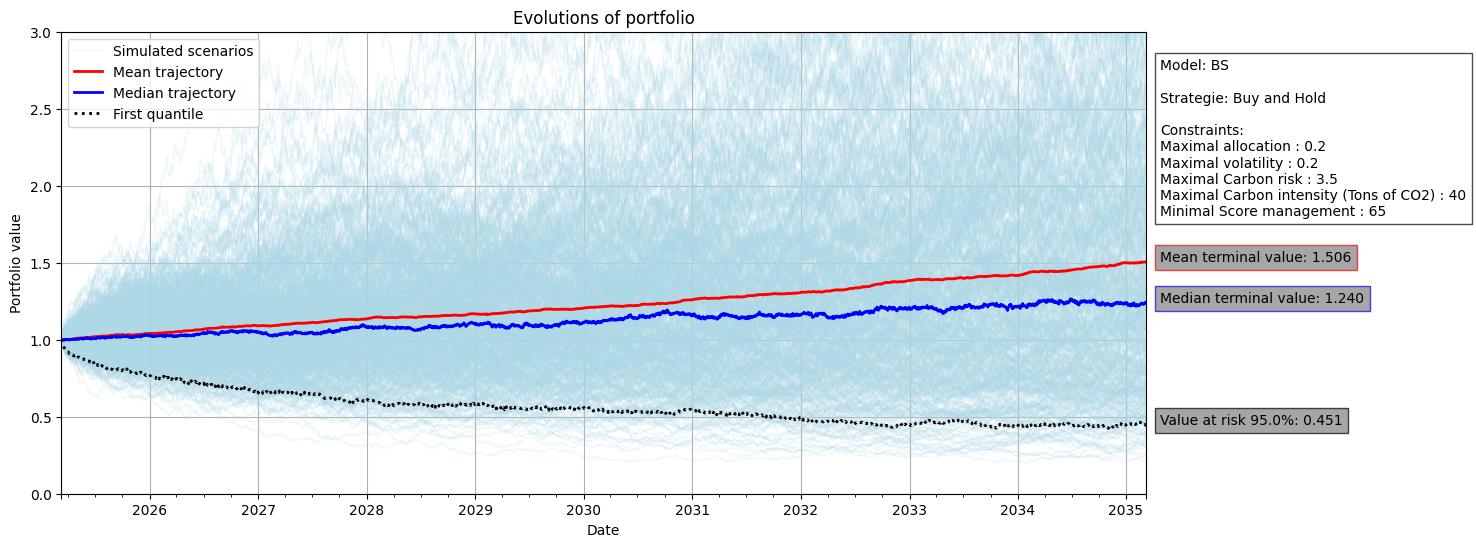

In [11]:
simulation_BuyH_sous_constrains.plot()

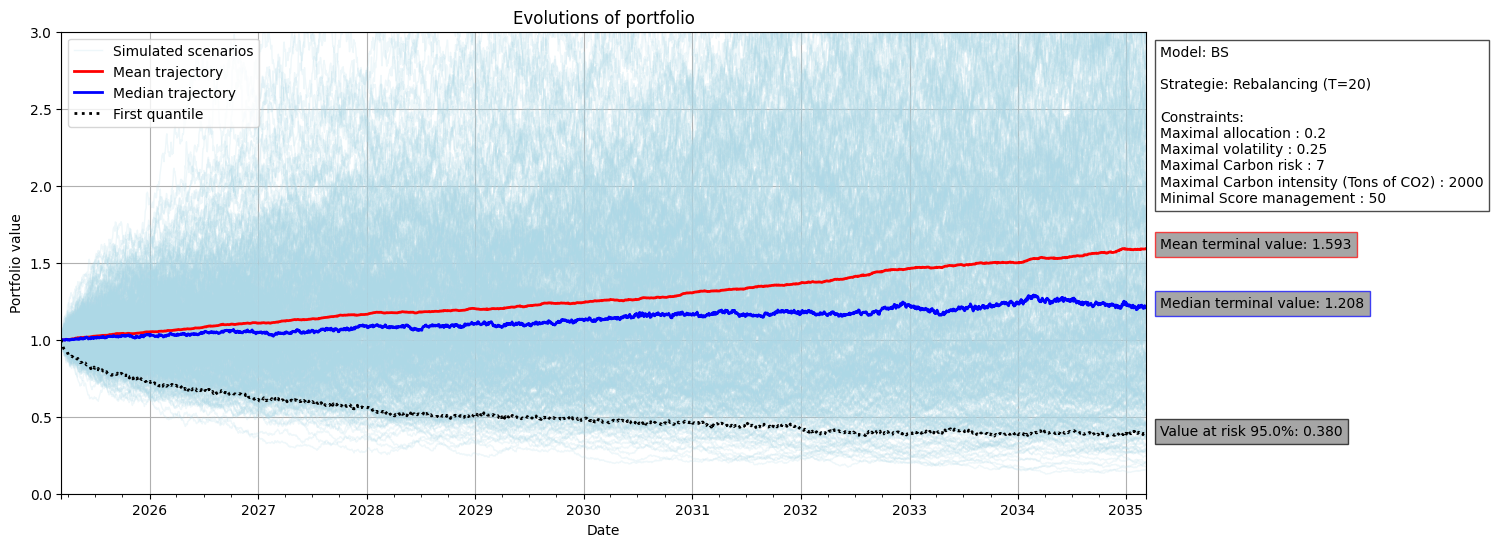

In [12]:
simulation_BuyH_sous_constrains2.plot()